In [0]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os, sys
import re
import seaborn as sns

In [0]:
from google.colab import files
uploaded = files.upload()

Saving BX-Book-Ratings.csv to BX-Book-Ratings.csv
Saving BX-Books.csv to BX-Books.csv
Saving BX-Users.csv to BX-Users.csv


In [0]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [0]:
#Loading data
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [0]:
#checking shapes of the datasets
print (books.shape)
print (users.shape)
print (ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


Book Dataset

In [0]:
#Exploring books dataset
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [0]:
#dropping last three columns containing image URLs which will not be required for analysis
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'],axis=1,inplace=True)

In [0]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [0]:
#checking data types of columns
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
dtype: object

In [0]:
#making this setting to display full text in columns
pd.set_option('display.max_colwidth', -1)

In [0]:
#checking the unique values of yearOfPublication
books.yearOfPublication.unique()

#Incorrect entries like Publishers name in the yearOf Publication column needs to be fixed


array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [0]:
#investigating the rows having 'DK Publishing Inc' as yearOfPublication
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [0]:
#From above, it is seen that bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [0]:
#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [0]:
#rechecking
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]
#corrections done

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)",James Buckley,2000,DK Publishing Inc


In [0]:
#investigating the rows having 'Gallimard' as yearOfPublication
books.loc[books.yearOfPublication == 'Gallimard',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [0]:
#making required corrections as above, keeping other fields intact
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [0]:
#rechecking
books.loc[books.ISBN == '2070426769',:]
#corrections done

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard


In [0]:
#Correcting the dtypes of yearOfPublication
books.yearOfPublication=pd.to_numeric(books.yearOfPublication, errors='coerce')

In [0]:
print (books['yearOfPublication'].unique())
#Now it can be seen that yearOfPublication has all values as integers

[2002 2001 1991 1999 2000 1993 1996 1988 2004 1998 1994 2003 1997 1983
 1979 1995 1982 1985 1992 1986 1978 1980 1952 1987 1990 1981 1989 1984
    0 1968 1961 1958 1974 1976 1971 1977 1975 1965 1941 1970 1962 1973
 1972 1960 1966 1920 1956 1959 1953 1951 1942 1963 1964 1969 1954 1950
 1967 2005 1957 1940 1937 1955 1946 1936 1930 2011 1925 1948 1943 1947
 1945 1923 2020 1939 1926 1938 2030 1911 1904 1949 1932 1928 1929 1927
 1931 1914 2050 1934 1910 1933 1902 1924 1921 1900 2038 2026 1944 1917
 1901 2010 1908 1906 1935 1806 2021 2012 2006 1909 2008 1378 1919 1922
 1897 2024 1376 2037]


In [0]:
#setting invalid years as NaN (for 0 and 2019 onwards)
books.loc[(books.yearOfPublication > 2019) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN

In [0]:
#replacing NaNs with mean value of yearOfPublication
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)

In [0]:
#rechecking
books.yearOfPublication.isnull().sum()
#No NaNs

0

In [0]:
#resetting the dtype as int32
books.yearOfPublication = books.yearOfPublication.astype(np.int32)

In [0]:
#exploring 'publisher' column
books.loc[books.publisher.isnull(),:]
#two NaNs

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [0]:
#investigating rows having NaNs
#Checking with rows having bookTitle as Tyrant Moon to see if we can get any clues
books.loc[(books.bookTitle == 'Tyrant Moon'),:]
#no clues

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN


In [0]:
#Checking with rows having bookTitle as Finder Keepers to see if we can get any clues
books.loc[(books.bookTitle == 'Finders Keepers'),:]
#all rows with different publisher and bookAuthor

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
10799,082177364X,Finders Keepers,Fern Michaels,2002,Zebra Books
42019,0070465037,Finders Keepers,Barbara Nickolae,1989,McGraw-Hill Companies
58264,0688118461,Finders Keepers,Emily Rodda,1993,Harpercollins Juvenile Books
66678,1575663236,Finders Keepers,Fern Michaels,1998,Kensington Publishing Corporation
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN
134309,0156309505,Finders Keepers,Will,1989,Voyager Books
173473,0973146907,Finders Keepers,Sean M. Costello,2002,Red Tower Publications
195885,0061083909,Finders Keepers,Sharon Sala,2003,HarperTorch
211874,0373261160,Finders Keepers,Elizabeth Travis,1993,Worldwide Library


In [0]:
#checking by bookAuthor to find patterns
books.loc[(books.bookAuthor == 'Linnea Sinclair'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [0]:
#checking by bookAuthor to find patterns
books.loc[(books.bookAuthor == 'Elaine Corvidae'),:]
#all having different publisher...no clues here

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
126762,1931696934,Winter's Orphans,Elaine Corvidae,2001,Novelbooks
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129001,0759901880,Wolfkin,Elaine Corvidae,2001,Hard Shell Word Factory


In [0]:
#since there is nothing in common to infer publisher for NaNs, replacing these with 'other'
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'other'

In [0]:
print (users.shape)
users.head()

(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [0]:
print(users.Age.unique())
#Age column has some invalid entries like nan, 0 and very high values like 100 and above

[ nan  18.  17.  61.  26.  14.  25.  19.  46.  55.  32.  24.  20.  34.
  23.  51.  31.  21.  44.  30.  57.  43.  37.  41.  54.  42.  50.  39.
  53.  47.  36.  28.  35.  13.  58.  49.  38.  45.  62.  63.  27.  33.
  29.  66.  40.  15.  60.   0.  79.  22.  16.  65.  59.  48.  72.  56.
  67.   1.  80.  52.  69.  71.  73.  78.   9.  64. 103. 104.  12.  74.
  75. 231.   3.  76.  83.  68. 119.  11.  77.   2.  70.  93.   8.   7.
   4.  81. 114. 230. 239.  10.   5. 148. 151.   6. 101. 201.  96.  84.
  82.  90. 123. 244. 133.  91. 128.  94.  85. 141. 110.  97. 219.  86.
 124.  92. 175. 172. 209. 212. 237.  87. 162. 100. 156. 136.  95.  89.
 106.  99. 108. 210.  88. 199. 147. 168. 132. 159. 186. 152. 102. 116.
 200. 115. 226. 137. 207. 229. 138. 109. 105. 228. 183. 204.  98. 223.
 113. 208. 107. 157. 111. 146. 118. 220. 143. 140. 189. 127.]


In [0]:
#Replacing values below 5 and above 90 by NaNs
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan

In [0]:
#replacing NaNs with mean
users.Age = users.Age.fillna(users.Age.mean())

In [0]:
#setting the data type as int
users.Age = users.Age.astype(np.int32)

In [0]:
#rechecking
print(users.Age.unique())


[34 18 17 61 26 14 25 19 46 55 32 24 20 23 51 31 21 44 30 57 43 37 41 54
 42 50 39 53 47 36 28 35 13 58 49 38 45 62 63 27 33 29 66 40 15 60 79 22
 16 65 59 48 72 56 67 80 52 69 71 73 78  9 64 12 74 75 76 83 68 11 77 70
  8  7 81 10  5  6 84 82 90 85 86 87 89 88]


In [0]:
#Ratings Dataset
#checking shape
ratings.shape

(1149780, 3)

In [0]:
#ratings dataset will have n_users*n_books entries if every user rated every item, this shows that the dataset is very sparse
n_users = users.shape[0]
n_books = books.shape[0]
print (n_users * n_books)

75670906880


In [0]:
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [0]:
#ratings dataset should have books only which exist in our books dataset, unless new books are added to books dataset
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

In [0]:
print (ratings.shape)
print (ratings_new.shape)
#it can be seen that many rows having book ISBN not part of books dataset got dropped off

(1149780, 3)
(1031136, 3)


In [0]:
#BX-Book-Ratings contains the book rating information. Ratings are either explicit, expressed on a scale from 1-10 
#higher values denoting higher appreciation, or implicit, expressed by 0
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [0]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]

In [0]:
#checking shapes
print (ratings_new.shape)
print (ratings_explicit.shape)
print (ratings_implicit.shape)

(1031136, 3)
(383842, 3)
(647294, 3)


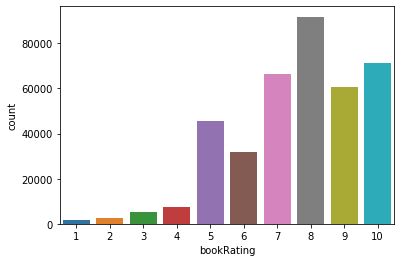

In [0]:
#plotting count of bookRating
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()
#It can be seen that higher ratings are more common amongst users and rating 8 has been rated highest number of times

In [0]:
#simple popularity based recommendation system

ratings_count = pd.DataFrame(ratings_explicit.groupby(['ISBN'])['bookRating'].sum())
top10 = ratings_count.sort_values('bookRating', ascending = False).head(10)
print ("Following books are recommended")
top10.merge(books, left_index = True, right_on = 'ISBN')

Following books are recommended


,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


In [0]:
#Similarly segregating users who have given explicit ratings from 1-10 and those whose implicit behavior was tracked
users_exp_ratings = users[users.userID.isin(ratings_explicit.userID)]
users_imp_ratings = users[users.userID.isin(ratings_implicit.userID)]

In [0]:
#checking shapes
print (users.shape)
print (users_exp_ratings.shape)
print (users_imp_ratings.shape)

(278858, 3)
(68091, 3)
(52451, 3)


In [0]:
#collaborative based

#to reduce the dataset, considering users who have rated atleast 100 books and books which have atleast 100 ratings
counts1 = ratings_explicit['userID'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(counts1[counts1 >= 100].index)]
counts = ratings_explicit['bookRating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['bookRating'].isin(counts[counts >= 100].index)]

In [0]:
#Generating ratings matrix from explicit ratings table
ratings_matrix = ratings_explicit.pivot(index='userID', columns='ISBN', values='bookRating')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()
#Notice that most of the values are NaN (undefined) implying absence of ratings

(449, 66574)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,0001056107,0001845039,0001935968,0001944711,0001952803,0001953877,0002000547,0002005018,0002005050,0002005557,0002006588,0002115328,0002116286,0002118580,0002154900,0002158973,0002163713,0002176181,0002176432,0002179695,0002181924,0002184974,0002190915,0002197154,0002223929,0002228394,000223257X,0002233509,0002239183,0002240114,...,987960170X,9974643058,999058284X,9992003766,9992059958,9993584185,9994256963,9994348337,9997405137,9997406567,9997406990,999740923X,9997409728,9997411757,9997411870,9997412044,9997412958,9997507002,999750805X,9997508769,9997512952,9997519086,9997555635,9998914140,B00001U0CP,B00005TZWI,B00006CRTE,B00006I4OX,B00007FYKW,B00008RWPV,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
n_users = ratings_matrix.shape[0] #considering only those users who gave explicit ratings
n_books = ratings_matrix.shape[1]
print (n_users, n_books)

449 66574


In [0]:
#since NaNs cannot be handled by training algorithms, replacing these by 0, which indicates absence of ratings
#setting data type
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [0]:
ratings_matrix.head()

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,0001056107,0001845039,0001935968,0001944711,0001952803,0001953877,0002000547,0002005018,0002005050,0002005557,0002006588,0002115328,0002116286,0002118580,0002154900,0002158973,0002163713,0002176181,0002176432,0002179695,0002181924,0002184974,0002190915,0002197154,0002223929,0002228394,000223257X,0002233509,0002239183,0002240114,...,987960170X,9974643058,999058284X,9992003766,9992059958,9993584185,9994256963,9994348337,9997405137,9997406567,9997406990,999740923X,9997409728,9997411757,9997411870,9997412044,9997412958,9997507002,999750805X,9997508769,9997512952,9997519086,9997555635,9998914140,B00001U0CP,B00005TZWI,B00006CRTE,B00006I4OX,B00007FYKW,B00008RWPV,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Training recommendation system

In [0]:
#setting global variables
global metric,k
k=10
metric='cosine'

User Based Recommendation System

In [0]:
#This function finds k similar users given the user_id and ratings matrix 
#These similarities are same as obtained via using pairwise_distances
def findksimilarusers(user_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
            
    return similarities,indices

In [0]:
#This function predicts rating for specified user-item combination based on user-based approach
def predict_userbased(user_id, item_id, ratings, metric = metric, k=k):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilarusers(user_id, ratings,metric, k) #similar users based on cosine similarity
    mean_rating = ratings.iloc[user_loc,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    #in case of very sparse datasets, using correlation metric for collaborative based approach may give negative ratings
    #which are handled here as below
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction

In [0]:
predict_userbased(11676,'0001056107',ratings_matrix);


Predicted rating for user 11676 -> item 0001056107: 2


Item - based recommendation system

In [0]:
#This function finds k similar items given the item_id and ratings matrix

def findksimilaritems(item_id, ratings, metric=metric, k=k):
    similarities=[]
    indices=[]
    ratings=ratings.T
    loc = ratings.index.get_loc(item_id)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()

    return similarities,indices

In [0]:
similarities,indices=findksimilaritems('0001056107',ratings_matrix)

In [0]:
#This function predicts the rating for specified user-item combination based on item-based approach
def predict_itembased(user_id, item_id, ratings, metric = metric, k=k):
    prediction= wtd_sum =0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilaritems(item_id, ratings) #similar users based on correlation coefficients
    sum_wt = np.sum(similarities)-1
    product=1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == item_loc:
            continue;
        else:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    
    #in case of very sparse datasets, using correlation metric for collaborative based approach may give negative ratings
    #which are handled here as below //code has been validated without the code snippet below, below snippet is to avoid negative
    #predictions which might arise in case of very sparse datasets when using correlation metric
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10

    print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))     
    
    return prediction

In [0]:
prediction = predict_itembased(11676,'0001056107',ratings_matrix)


Predicted rating for user 11676 -> item 0001056107: 1


In [0]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [0]:
#This function utilizes above functions to recommend items for item/user based approach and cosine/correlation. 
#Recommendations are made if the predicted rating for an item is >= to 6,and the items have not been rated already
def recommendItem(user_id, ratings, metric=metric):    
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print ("User id should be a valid integer from this list :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(ratings_matrix.index.values))))
    else:    
        ids = ['Item-based (correlation)','Item-based (cosine)','User-based (correlation)','User-based (cosine)']
        select = widgets.Dropdown(options=ids, value=ids[0],description='Select approach', width='1000px')
        def on_change(change):
            clear_output(wait=True)
            prediction = []            
            if change['type'] == 'change' and change['name'] == 'value':            
                if (select.value == 'Item-based (correlation)') | (select.value == 'User-based (correlation)') :
                    metric = 'correlation'
                else:                       
                    metric = 'cosine'   
                with suppress_stdout():
                    if (select.value == 'Item-based (correlation)') | (select.value == 'Item-based (cosine)'):
                        for i in range(ratings.shape[1]):
                            if (ratings[str(ratings.columns[i])][user_id] !=0): #not rated already
                                prediction.append(predict_itembased(user_id, str(ratings.columns[i]) ,ratings, metric))
                            else:                    
                                prediction.append(-1) #for already rated items
                    else:
                        for i in range(ratings.shape[1]):
                            if (ratings[str(ratings.columns[i])][user_id] !=0): #not rated already
                                prediction.append(predict_userbased(user_id, str(ratings.columns[i]) ,ratings, metric))
                            else:                    
                                prediction.append(-1) #for already rated items
                prediction = pd.Series(prediction)
                prediction = prediction.sort_values(ascending=False)
                recommended = prediction[:10]
                print ("As per {0} approach, the following books are recommended:".format(select.value))
                for i in range(len(recommended)):
                     print ("{0}. {1}".format(i+1,books.bookTitle[recommended.index[i]]))                        
        select.observe(on_change)
        display(select)

In [0]:
recommendItem(999999,ratings_matrix)

User id should be a valid integer from this list :

   2033   2110   2276   4017   4385   5582   6242   6251   6543   6575
   7286   7346   8067   8245   8681   8890  10560  11676  11993  12538
  12824  12982  13552  13850  14422  15408  15418  16634  16795  16966
  17950  19085  21014  23768  23872  23902  25409  25601  25981  26535
  26544  26583  28591  28634  29259  30276  30511  30711  30735  30810
  31315  31556  31826  32773  33145  35433  35836  35857  35859  36299
  36554  36606  36609  36836  36907  37644  37712  37950  38023  38273
  38281  39281  39467  40889  40943  43246  43910  46398  47316  48025
  48494  49144  49889  51883  52199  52350  52584  52614  52917  53220
  55187  55490  55492  56271  56399  56447  56554  56959  59172  60244
  60337  60707  63714  63956  65258  66942  67840  68555  69078  69389
  69697  70415  70594  70666  72352  73681  75591  75819  76151  76223
  76499  76626  78553  78783  78834  78973  79441  81492  81560  83287
  83637  83671  85526  85

In [0]:
recommendItem(4385, ratings_matrix)

As per Item-based (cosine) approach, the following books are recommended:
1. My Wicked Wicked Ways
2. Fair Peril
3. Wolfpointe
4. A Nest of Ninnies
5. A Bitter Legacy
6. A Hymn Before Battle
7. Thomas the Rhymer
8. Gatherer of Clouds (Initiate Brother Duology)
9. Wege zum Ruhm: 13 Hilfestellungen fÃ¼r junge KÃ¼nstler und 1 Warnung
10. Love In Bloom's


In [0]:
recommendItem(4200, ratings_matrix)

User id should be a valid integer from this list :

   2033   2110   2276   4017   4385   5582   6242   6251   6543   6575
   7286   7346   8067   8245   8681   8890  10560  11676  11993  12538
  12824  12982  13552  13850  14422  15408  15418  16634  16795  16966
  17950  19085  21014  23768  23872  23902  25409  25601  25981  26535
  26544  26583  28591  28634  29259  30276  30511  30711  30735  30810
  31315  31556  31826  32773  33145  35433  35836  35857  35859  36299
  36554  36606  36609  36836  36907  37644  37712  37950  38023  38273
  38281  39281  39467  40889  40943  43246  43910  46398  47316  48025
  48494  49144  49889  51883  52199  52350  52584  52614  52917  53220
  55187  55490  55492  56271  56399  56447  56554  56959  59172  60244
  60337  60707  63714  63956  65258  66942  67840  68555  69078  69389
  69697  70415  70594  70666  72352  73681  75591  75819  76151  76223
  76499  76626  78553  78783  78834  78973  79441  81492  81560  83287
  83637  83671  85526  85

In [0]:
recommendItem(271448, ratings_matrix)

As per User-based (correlation) approach, the following books are recommended:
1. Memorial Do Convento
2. Self Matters : Creating Your Life from the Inside Out
3. Lord of Chaos (The Wheel of Time, Book 6)
4. GREAT BRIDGE : The Epic Story of the Building of the Brooklyn Bridge
5. Molly Saves the Day: A Summer Story (American Girls Collection)
6. Stay Out of the Basement (Goosebumps, No 2)
7. My Century: A Novel
8. They Went Broke?! : Bankruptcies and Money Disaster of the Rich &amp; Famous
9. A Philip Roth Reader
10. Fahrenheit 451 and Related Readings
